In [81]:
%matplotlib notebook
import numpy as np
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
from glob import glob
from tqdm.auto import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from scipy import stats

import IPython

from matplotlib.animation import ArtistAnimation


%matplotlib inline
# All imports

from random import choice
from copy import copy
import time
from IPython import display
import math

In [2]:
hdu = fits.open('silo_eboss_detections-1.0.1.fits')
dat = Table(hdu[1].data)
dat2 = Table(hdu[2].data)

In [224]:
# dat.keys() #'DETECTIONS'

In [225]:
# dat2.keys() #Emission Line Analysis

In [6]:
plates = hdu['DETECTIONS'].data['PLATE']
mjds = hdu['DETECTIONS'].data['MJD']
fiberids = hdu['DETECTIONS'].data['FIBER_INDEX']

In [163]:
flux_li = []

for item in hdu['DETECTIONS'].data['FLUX']:
    #print(item.shape)
    flux_li.append(item[:4500].reshape(1, item[:4500].shape[0]))
    #print(item.reshape(1, item.shape[0]).shape)
flux_sample = np.concatenate((flux_li))
X = flux_sample.copy()

### PCA

In [82]:
def init_pca(X, n_comp):
    pca = PCA(n_comp, svd_solver='full')
    Xproj =pca.fit_transform(X)
    pca_comps = pca.components_
    return pca, Xproj, pca_comps

In [10]:
#Eigenimages
def show_eigen_spectra(Xproj, pca_comps, let_idx=0, dim = 16):
    fig, axes = plt.subplots(1, pca_comps.shape[0])
    fig.set_size_inches(30, 5)
    coeffs = (Xproj[let_idx])
    for i in range(pca_comps.shape[0]):    
        axes[i].plot(coeffs[i]*pca_comps[i])
        axes[i].axis('off')
    print(let_idx)
    print('Coeffs', coeffs)    
    plt.show()

In [11]:
def show_pca_spectra(Xproj, pca_comps, let_idx = 0, dim = 16):
    show_eigen_spectra(Xproj, pca_comps, let_idx)
    rec_let = np.zeros((1, 4500))
    coeffs = (Xproj[let_idx])
    ims = []
    fig = plt.figure()
    for i in range(pca_comps.shape[0]):
        #linear combination
        rec_let += coeffs[i]*pca_comps[i]#.reshape((1, 4500))
    ax = plt.subplot(111)
    ax.axis('off')
    ax.imshow(rec_let)
    plt.show()

In [114]:
def rec_letFun(Xproj, pca_comps, let_idx, dim = 16):
    rec_let = np.zeros((1, 4500))
    coeffs = (Xproj[let_idx])
    for i in range(pca_comps.shape[0]):
        #linear combination
        rec_let += coeffs[i]*pca_comps[i].reshape((1, 4500))
    return rec_let+ pca.mean_

In [136]:
import IPython
n_comp = 1551
pca, Xproj, pca_comps = init_pca(X, n_comp)

In [135]:
n_comp = 7
pca7, Xproj7, pca_comps7 = init_pca(X, n_comp)

In [146]:
n_comp = 25
pca25, Xproj25, pca_comps25 = init_pca(X, n_comp)

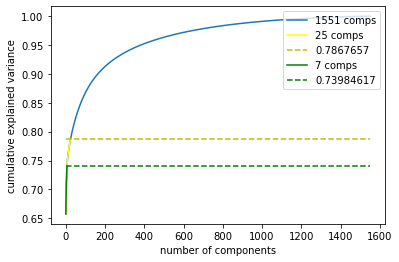

In [200]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='1551 comps')
plt.plot(np.cumsum(pca25.explained_variance_ratio_), 'yellow', label='25 comps')
plt.plot([0, 1551], [np.cumsum(pca25.explained_variance_ratio_).max(), np.cumsum(pca25.explained_variance_ratio_).max()], 'y--', label=np.cumsum(pca25.explained_variance_ratio_).max())
plt.plot(np.cumsum(pca7.explained_variance_ratio_), 'green', label='7 comps')
plt.plot([0, 1551], [np.cumsum(pca7.explained_variance_ratio_).max(), np.cumsum(pca7.explained_variance_ratio_).max()], 'g--', label=np.cumsum(pca7.explained_variance_ratio_).max())
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend(loc='upper right')
plt.show()

In [105]:
Xmean=X.mean(axis=0)
PCAmean = pca.mean_ #== zeroth component

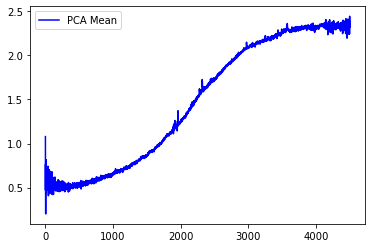

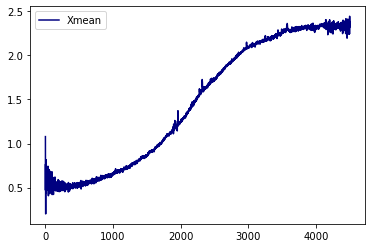

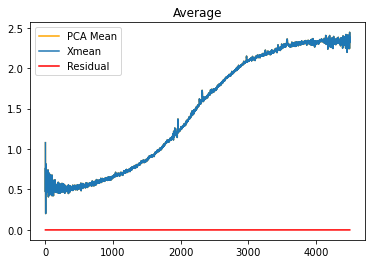

In [106]:
plt.plot(PCAmean,label='PCA Mean', c='blue')
plt.legend()
plt.show()


plt.plot(Xmean, label='Xmean', c='navy')
plt.legend()
plt.show()
plt.title('Average')
plt.plot(PCAmean,label='PCA Mean', c='orange')
plt.plot(Xmean, label='Xmean')
plt.plot(PCAmean-Xmean, c='red', label='Residual')
plt.legend()
plt.show()

##### Example of PCA

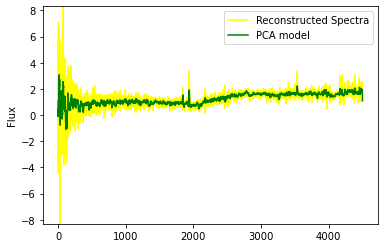

In [131]:
for i in range(20,21):    
    rec_let = rec_letFun(Xproj, pca_comps, let_idx=i)
    window_size = 10
    PCAmodel = np.convolve(rec_let[0]+pca_comps[0], np.ones((window_size,))/window_size, mode='same') 
    plt.plot(rec_let[0]+pca_comps[0], label='Reconstructed Spectra', color='yellow')
    plt.plot(smooth, label='PCA model', color='green')
    plt.ylabel('Flux')
    plt.ylim(rec_let[0].min(), rec_let[0].max())
    plt.legend()
    plt.show()

### Emission and Absorption Lines

In [201]:
emissionLines = Table.read('GalaxySpectralEmissionLines.csv').to_pandas()
absLines = Table.read('GalaxySpectraAbsorptionLines.csv').to_pandas()

In [203]:
emissionLine = []
for item in emissionLines['Rest Wave'].values:
    emissionLine.append(item)
emissionLine = np.array(emissionLine)

print(emissionLine)

[1033.3   1215.67  1239.42  1305.53  1335.52  1397.61  1399.8   1545.86
 1640.4   1665.85  1857.41  1908.27  2326.    2439.5   2800.32  3346.79
 3426.85  3728.3   3798.976 3836.47  3889.    4072.3   4102.89  4341.68
 4364.436 4862.68  4960.295 5008.24  6302.046 6365.536 6549.86  6564.61
 6585.27  6707.89  6718.29  6732.67 ]


In [205]:
emissionLineName_li = []
for item in emissionLines['Species'].values:
    emissionLineName_li.append(item)
emissionLineName = emissionLineName_li.copy()
emissionLineName = np.array(emissionLineName)
print(emissionLineName)

['OVI' 'Lyα' 'NV' 'OI' 'CII' 'SiIV' 'SiIV+OIV' 'CIV' 'HeII' 'OIII' 'AlIII'
 'CIII' 'CII' 'NeIV' 'MgII' 'NeV' 'NeVI' 'OII' 'Hθ' 'Hη' 'HeI' 'SII' 'Hδ'
 'Hγ' 'OIII' 'Hβ' 'OIII' 'OIII' 'OI' 'OI' 'NII' 'Hα' 'NII' 'Li' 'SII'
 'SII']


In [204]:
absLine = []
for item in absLines['Rest Wave'].values:
    absLine.append(item)
absLine = np.array(absLine)

print(absLine)

[3934.777 3969.588 4305.61  5176.7   5895.6   8500.36  8544.44  8664.52 ]


In [206]:
absLineName_li = []
for item in absLines['Species'].values:
    absLineName_li.append(item)
absLineName = absLineName_li.copy()
absLineName = np.array(absLineName)
print(absLineName)

['K' 'H' 'G' 'Mg' 'Na' 'CaII' 'CaII' 'CaII']


### Plotting


OII(b, a) doublet: 
10.191682

HId: 
0.0027149825

HIc: 
2.1933603

HIb: 
0.54227227

OIIIb: 
0.0

OIIIa: 
1.0161233

Single Gauss of OII(b, a): 
10.191682


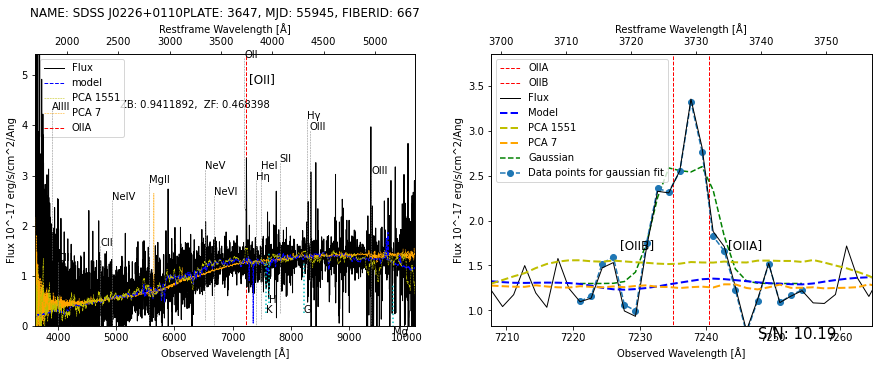

In [226]:
for index in range(4, 5):
    plate = plates[index]
    mjd = mjds[index]
    fiberid = fiberids[index]

    data_for_plate_mjd_fiberid = hdu['DETECTIONS'].data[index]
    
    #Now how about we get data for an emission line, such as the spectra for the OII(b,a) Doublet
    index_for_plate_mjd_fiberid =  np.where((hdu['EMISSION_LINE_ANALYSIS'].data['DETECTION_CATALOG_ID'] == data_for_plate_mjd_fiberid['CATALOG_ID']) & (hdu['EMISSION_LINE_ANALYSIS'].data['NAME'] == 'OII(b, a) doublet'))[0][0]

    emline_for_plate_mjd_fiberid = hdu['EMISSION_LINE_ANALYSIS'].data[index_for_plate_mjd_fiberid]
    
    z = data_for_plate_mjd_fiberid['DETECTION_Z']
    redshift = data_for_plate_mjd_fiberid['Z_NOQSO']
    
    wave_vector = data_for_plate_mjd_fiberid['WAVE'][:4500]
    restWave = wave_vector / (1+z)
    
    #Gauss Model: Gaussian model of residual flux
    gauss_model = emline_for_plate_mjd_fiberid['GAUSS_MODEL']
    #Model Wave Base: Wavelength base of Gaussian model
    model_wave = emline_for_plate_mjd_fiberid['MODEL_WAVE_BASE']
    #Model made from given PCA, Foreground model generated by SILO
    model = data_for_plate_mjd_fiberid['MODEL_SILO'][:4500]
    
    #Gaussian convolved signal-to-noise of spectra
    sn_spectra = data_for_plate_mjd_fiberid['SN_SPECTRA_SG'][:4500]

    residual_flux = data_for_plate_mjd_fiberid['RESIDUAL_FLUX'][:4500]
    flux = data_for_plate_mjd_fiberid['FLUX'][:4500]
    
    emline_types = hdu['EMISSION_LINE_ANALYSIS'].data['NAME'][np.where(hdu['EMISSION_LINE_ANALYSIS'].data['DETECTION_CATALOG_ID'] == data_for_plate_mjd_fiberid['CATALOG_ID'])]
    for emline_type in emline_types:
        print('\n'+emline_type+': ')
        index_for_plate_mjd_fiberid = np.where((hdu['EMISSION_LINE_ANALYSIS'].data['DETECTION_CATALOG_ID'] == data_for_plate_mjd_fiberid['CATALOG_ID'])
        & (hdu['EMISSION_LINE_ANALYSIS'].data['NAME'] == emline_type))[0][0]
        emline_for_plate_mjd_fiberid = hdu['EMISSION_LINE_ANALYSIS'].data[index_for_plate_mjd_fiberid]
        print(emline_for_plate_mjd_fiberid['SN'])
        
    O2A = hdu[0].header['OIIA']*(1+z)
    O2B = hdu[0].header['OIIB']*(1+z)
    
    HIB = hdu[0].header['HIb']*(1+z)
    HIC = hdu[0].header['HIc']*(1+z)
    
    observed_wavelength = np.sqrt(hdu[0].header['OIIB']*hdu[0].header['OIIA']) * (1+z)
    emline_index = np.abs(wave_vector - observed_wavelength).argmin()
    
                                            #Plot
    rec_let = rec_letFun(Xproj, pca_comps, let_idx=index)
    rec_let7 = rec_letFun(Xproj7, pca_comps7, let_idx=index)
    rec_let25 = rec_letFun(Xproj25, pca_comps25, let_idx=index)
    PCApmf = rec_let[0]+pca_comps[0]
    PCA25 = rec_let25[0]+pca_comps25[0]
    window_size = 30
    PCAmodel = np.convolve(PCApmf, np.ones((window_size,))/window_size, mode='same') 
    
    PCApmf7 = rec_let7[0]+pca_comps7[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.plot(wave_vector, flux, 'k',linewidth=1,zorder=11, label='Flux')
    ## Given model
    ax1.plot(wave_vector, model, 'b', linestyle='--', linewidth=1,zorder=20, label='model')
    ##PCA model
    ax1.plot(wave_vector, PCAmodel, 'y', linestyle='--', linewidth=0.5,zorder=21, label='PCA 1551')
    ax1.plot(wave_vector, PCApmf7, 'orange', linestyle='--', linewidth=0.5,zorder=19, label='PCA 7')
#     ax1.plot(wave_vector, PCA25, 'y', linestyle='--', linewidth=0.5,zorder=19, label='PCA 25')

    
    ax1.set_xlim(wave_vector.min(),wave_vector.max())
    ax1.set_ylim(0, flux.max()/2.5)
    ax1.text(x=np.average((O2A,O2B))+50,y=residual_flux.max()/2.5-.5,s='[OII]',ha='left',fontsize=12)
    ax1.plot([np.average((O2A,O2B)),np.average((O2A,O2B))],[-100,100],c='red',linestyle='--',linewidth=1,label='OIIA',zorder=10)
    ax1.set_xlabel('Observed Wavelength [Å]')
    ax1.set_ylabel('Flux 10^-17 erg/s/cm^2/Ang')
    axes1 = ax1.twiny()
    axes1.set_xlabel('Restframe Wavelength [Å]')
    axes1.plot(restWave, flux, zorder=1, alpha=0.0001)
    
                         ## Emission and Absorption Lines
    for j in range(len(restWave)):
        for k in range(len(emissionLine)):
            if ( math.isclose(emissionLine[k], restWave[j], abs_tol=0.3) ):
                axes1.plot([restWave[j], restWave[j]], [flux[j]-1, flux[j].max()+2], c='gray', linestyle='--', linewidth=0.5, zorder=0)
                axes1.text(restWave[j], flux[j]+2, str(emissionLineName[k]))
        for h in range(len(absLine)):
            if ( math.isclose(absLine[h], restWave[j], abs_tol=0.3) ):
                axes1.plot([restWave[j], restWave[j]], [flux[j]-1, flux[j].max()], 'c:', zorder=0)
                axes1.text(restWave[j], flux[j]-1, str(absLineName[h]))
    
    ax1.text(wave_vector.max()/2, residual_flux.max()/2.5-1, 'ZB: '+str(z)+ ',  ZF: '+str(redshift))
    ax1.set_title('NAME: '+str(data_for_plate_mjd_fiberid['SDSS_TARGET_NAME']) + 'PLATE: '+str(plate)+ ', MJD: '+str(mjd)+', FIBERID: '+str(fiberid))
    ax1.legend(loc='upper left')

    midpoint = np.average((O2A,O2B)) / (z+1)
    ax2.plot([O2A,O2A],[-100,100],c='red',linestyle='--',linewidth=1,label='OIIA')
    ax2.plot([O2B,O2B],[-100,100],c='red',linestyle='--',linewidth=1,label='OIIB')
    
    ax2.text(x=np.average((O2A,O2B))+10,y=residual_flux.max()/5-2,s='S/N: {:0.2f}'.format(emline_for_plate_mjd_fiberid['SN']),fontsize=15)
    ax2.text(x=O2A+8,y=residual_flux.max()/5-1,s='[OIIA]',ha='right',fontsize=12)
    ax2.text(x=O2B-8,y=residual_flux.max()/5-1,s='[OIIB]',ha='left',fontsize=12)

    #Now lets plot the flux-model spectra at the position of the OII(b,a) doublet
    ax2.plot(wave_vector, flux, 'k',linewidth=1, zorder=11, label='Flux')
    ax2.plot(wave_vector, model, 'b', linestyle='--',linewidth=2,zorder=15, label='Model')
    ax2.plot(wave_vector, PCAmodel, 'y', linestyle='--', linewidth=2,zorder=21, label='PCA 1551')
    ax2.plot(wave_vector, PCApmf7, 'orange', linestyle='--', linewidth=2,zorder=21, label='PCA 7')
#     ax2.plot(wave_vector, PCA25, 'y', linestyle='--', linewidth=2,zorder=19, label='PCA 25')
    
    fitted_residual_flux = emline_for_plate_mjd_fiberid['FITTED_RESIDUAL_FLUX']

    for j in range(len(wave_vector)):
        if ( math.isclose(wave_vector[j], np.average((O2A,O2B)), abs_tol=0.1)):
            high_point = flux[j]
            low_point = model[j]
            for k in range(len(model_wave)):
                if model_wave[k] == wave_vector[j]:
                    mid_point = np.round(fitted_residual_flux[k], 2)
                    difference = np.round(high_point - mid_point, 1)
                    ax2.plot(model_wave, gauss_model+difference, 'g--', label='Gaussian')
                    ax2.plot(model_wave, fitted_residual_flux+difference, 'o--', label='Data points for gaussian fit')
    
    ax2.set_xlabel('Observed Wavelength [Å]')
    ax2.set_ylabel('Flux 10^-17 erg/s/cm^2/Ang')
    ax2.set_ylim(low_point-.5,high_point+.5)
    ax2.set_xlim(np.average((O2A,O2B))-30,(3727*(1+z))+30)
    axes2 = ax2.twiny()
    axes2.set_xlabel('Restframe Wavelength [Å]')
    axes2.plot(restWave, residual_flux, zorder=1, alpha=0.0001)
    axes2.set_ylim(low_point-.5,high_point+.5) 
    axes2.set_xlim((midpoint-30),(3727 + 30))
    ax2.legend(loc='upper left')
    fig.align_xlabels()
    plt.show()    